In [25]:
from __future__ import print_function
import numpy as np 
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torchvision.utils as vutils
import matplotlib.pyplot as plt 


DIM = 20
EPOCHS = 10
torch.manual_seed(1)
device = torch.device("cpu")


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=False)

# TA model in sheet3_solution.ipynb
# altered according to https://github.com/cunningham-lab/cb_and_cc/blob/master/cb/utils.py
class BetaDistVAE(nn.Module):
    def __init__(self, hidden_dims=[300, 50, DIM, 50, 300], data_dim=784):
        super().__init__()
        assert len(hidden_dims) == 5, "Insufficiently number of dimensions!"
        self.data_dim = data_dim
        self.device = device
        
        # self.beta_reg = nn.Parameter(3*torch.ones(1))
        # define IO
        self.in_layer = nn.Linear(data_dim, hidden_dims[0])
        self.out_layer = nn.Linear(hidden_dims[-1], 2*data_dim)
        # self.out_layer_alpha = nn.Linear(hidden_dims[-1], data_dim)
        # self.out_layer_beta = nn.Linear(hidden_dims[-1], data_dim)
        # hidden layer
        self.enc_h = nn.Linear(hidden_dims[0], hidden_dims[1])
        # define hidden and latent
        self.enc_mu = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.enc_sigma = nn.Linear(hidden_dims[1], hidden_dims[2])
        # hidden layer decoder
        self.dec_h = nn.Linear(hidden_dims[2], hidden_dims[-2])
        self.dec_layer = nn.Linear(hidden_dims[-2], hidden_dims[-1])
        self.to(device)
        
    def encode(self, x: torch.Tensor):
        h1 = F.relu(self.in_layer(x))
        h2 = F.relu(self.enc_h(h1))
        return self.enc_mu(h2), self.enc_sigma(h2)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        h3 = F.relu(self.dec_h(z))
        h4 = F.relu(self.dec_layer(h3))
        # ALTERED
        beta_params = self.out_layer(h4)
        plus = nn.Softplus()
        alphas = plus(beta_params[:, :self.data_dim])
        betas = 1e-6 + plus(beta_params[:, self.data_dim:])
        # alpha_layer = self.out_layer_alpha(h4)
        # beta_layer = self.out_layer_beta(h4)
        # plus = nn.Softplus()
        # alphas = 1e-6 + plus(alpha_layer)
        # betas = 1e-6 + plus(beta_layer)
        return alphas, betas

    def forward(self, x: torch.Tensor):
        mu, logvar = self.encode(x.view(-1, self.data_dim))
        z = self.reparameterize(mu, logvar)
        alphas, betas = self.decode(z)
        return z, alphas, betas, mu, logvar


model = BetaDistVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# https://github.com/Robert-Aduviri/Continuous-Bernoulli-VAE
# the following function is copied from the above github repo 
# where I did not alter anything
def sumlogC(x , eps = 1e-5):
    '''
    Numerically stable implementation of 
    sum of logarithm of Continous Bernoulli
    constant C, using Taylor 2nd degree approximation
        
    Parameter
    ----------
    x : Tensor of dimensions (batch_size, dim)
        x takes values in (0,1)
    ''' 
    x = torch.clamp(x, eps, 1.-eps) 
    mask = torch.abs(x - 0.5).ge(eps)
    far = torch.masked_select(x, mask)
    close = torch.masked_select(x, ~mask)
    far_values =  torch.log( (torch.log(1. - far) - torch.log(far)).div(1. - 2. * far) )
    close_values = torch.log(torch.tensor((2.))) + torch.log(1. + torch.pow( 1. - 2. * close, 2)/3. )
    return far_values.sum() + close_values.sum()

# https://github.com/cunningham-lab/cb_and_cc/blob/master/cb/beta_distr_vae_mnist.ipynb 
# the following function is altered according to the above link
def beta_loss_function(z, alphas, betas, x, mu, logvar, beta_reg=1):
    x = x.view(-1, 784)
    
    # clipped_x = torch.clamp(x, 1e-4, 1 - 1e-4)
    # log_norm_const = torch.lgamma(alphas + betas) - torch.lgamma(alphas) - torch.lgamma(betas)
    # log_p_all = torch.sum((alphas - 1.0) * torch.log(clipped_x) + (betas - 1.0) * torch.log(1.0 - clipped_x)
    #                         + log_norm_const, 1)
    # log_p = torch.mean(log_p_all)
    # log_iw = log_p_all + torch.sum(-0.5 * torch.square(z), 1)
    # std = torch.exp(0.5*logvar)
    # log_iw = log_iw + torch.sum(torch.log(1e-8 + std) + torch.square(mu - z) / (2.0 * torch.square(std)), 1)
    # KL = 0.5 * torch.sum(torch.square(mu) + torch.square(std) - torch.log(1e-8 + torch.square(std)) - 1.0, 1)
    # KL = torch.mean(KL)
    
    # return -log_p + beta_reg * KL
    recon_x = alphas / (alphas + betas)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') 
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # logC = sumlogC(recon_x)
    return BCE + 2*KLD #+ logC
    

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        z, alphas, betas, mu, logvar = model(data)
        loss = beta_loss_function(z, alphas, betas, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
    
    train_loss /= len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss))
    


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            z, alphas, betas, mu, logvar = model(data)
            loss = beta_loss_function(z, alphas, betas, data, mu, logvar)
            test_loss += loss.item()
            
            if i == 0:
                n = min(data.size(0), 8)
                recon_batch = alphas / (alphas + betas)
                recon_batch = recon_batch.view(128, 1, 28, 28)
                comparison = torch.cat([data[:n],
                                        recon_batch[:n]])
                
                # save_image(comparison.cpu(),
                #            'betaresults/reconstruction_' + str(epoch) + '.png', nrow=n)
                plt.figure(figsize=(10, 4))
                for i in range(1, 2*n+1):
                    ax = plt.subplot(2,n,i)
                    plt.imshow(comparison.cpu().detach().numpy()[i-1, 0,:,:], cmap="gray")
                    ax.get_xaxis().set_visible(False)
                    ax.get_yaxis().set_visible(False)
                    ax.margins(0,0)
                plt.savefig('betaresults/reconstruction_' + str(epoch) + '.png')
                plt.close()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, DIM).to(device)
        sample = model.decode(sample)
        sample = sample[0] / (sample[0] + sample[1]) 
        save_image(sample.view(64, 1, 28, 28),
                    'betaresults/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 546.643799
Train Epoch: 1 [1280/60000 (2%)]	Loss: 365.825653
Train Epoch: 1 [2560/60000 (4%)]	Loss: 248.637787
Train Epoch: 1 [3840/60000 (6%)]	Loss: 220.761414
Train Epoch: 1 [5120/60000 (9%)]	Loss: 213.435242
Train Epoch: 1 [6400/60000 (11%)]	Loss: 207.775696
Train Epoch: 1 [7680/60000 (13%)]	Loss: 210.552887
Train Epoch: 1 [8960/60000 (15%)]	Loss: 214.521423
Train Epoch: 1 [10240/60000 (17%)]	Loss: 210.476044
Train Epoch: 1 [11520/60000 (19%)]	Loss: 200.152023
Train Epoch: 1 [12800/60000 (21%)]	Loss: 198.272064
Train Epoch: 1 [14080/60000 (23%)]	Loss: 203.736664
Train Epoch: 1 [15360/60000 (26%)]	Loss: 197.824722
Train Epoch: 1 [16640/60000 (28%)]	Loss: 198.122559
Train Epoch: 1 [17920/60000 (30%)]	Loss: 202.573196
Train Epoch: 1 [19200/60000 (32%)]	Loss: 189.882538
Train Epoch: 1 [20480/60000 (34%)]	Loss: 197.471619
Train Epoch: 1 [21760/60000 (36%)]	Loss: 192.110870
Train Epoch: 1 [23040/60000 (38%)]	Loss: 199.080780
Train Epoch: 1 [24320/60000 

KeyboardInterrupt: 

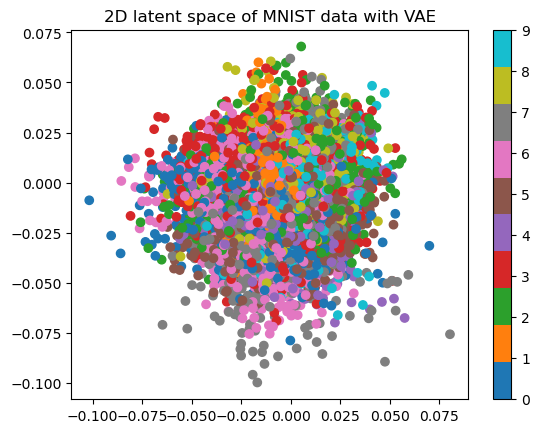

In [ ]:
def plot_latent(model, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        # print(i)
        # print(x.shape)
        # print(y.shape)
        # print(x.to(device).reshape(-1, 784).shape)
        mu, logvar = model.encode(x.view(-1, 784))
        # z = model.reparameterize(mu, logvar).detach().numpy()
        z = mu.detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        plt.title("2D latent space of MNIST data with VAE")
        if i > num_batches:
            plt.colorbar()
            break

# print(train_loader)
plot_latent(model, train_loader, 128)

In [ ]:
# https://avandekleut.github.io/vae/
def plot_reconstructed(model, r0=(-2.5, 2.5), r1=(-2.5, 2.5), n=15):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = model.decode(z)
            x_hat = x_hat.reshape(28, 28).detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

plot_reconstructed(model)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 20x50)

In [ ]:
train_loss_vals_total = np.array(train_loss_vals_total)
test_loss_vals_total = np.array(test_loss_vals_total)

np.save("tmp/vae_train_loss_vals_total.npy", train_loss_vals_total)
np.save("tmp/vae_test_loss_vals_total.npy", test_loss_vals_total)


In [ ]:
# cbvae_train_loss = np.sum(train_loss_vals_total, axis=1)
# cbvae_test_loss = np.sum(test_loss_vals_total, axis=1)

# cbvae_train_loss = np.sum(np.load("tmp/cbvae_train_loss_vals_total.npy"), axis=1)
# cbvae_test_loss = np.sum(np.load("tmp/cbvae_test_loss_vals_total.npy"), axis=1)
# vae_train_loss = np.sum(np.load("tmp/vae_train_loss_vals_total.npy"), axis=1)
# vae_test_loss = np.sum(np.load("tmp/vae_test_loss_vals_total.npy"), axis=1)

# plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in cbvae_train_loss], lw=2.5, label="CBVAE train")
# plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in cbvae_test_loss], lw=2.5, label="CBVAE test")
# plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in vae_train_loss], lw=2.5, label="VAE train")
# plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in vae_test_loss], lw=2.5, label="VAE test")

# plt.xlabel("epoch")
# plt.ylabel("loss\n BCE+KLD+logC")
# plt.title("Loss of VAE and CBVAE on MNIST")
# plt.legend()
# plt.show()